In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [5]:
original = pd.read_csv("../data/BankChurners.csv")
temp4 = pd.read_csv("../temp4.csv")
technical_df = pd.read_csv("../data/User churn.csv")

This section aims to generate artificial data for digital engagement.

### Feature Selection

In [9]:
required_features_original = ['CLIENTNUM', 'Gender', 'Customer_Age', 'Marital_Status', 'Dependent_count', 'Attrition_Flag']
subset_original2 = original.loc[:,required_features_original]

required_features_tech = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Churn',
                          'PhoneService', 'InternetService', 'TechSupport', 'PaperlessBilling', 'PaymentMethod']
subset_technical = technical_df.loc[:,required_features_tech]

### Data Cleaning

In [12]:
subset_original2['SeniorCitizen'] = (subset_original2['Customer_Age'] > 60).astype(int)
subset_original2['Dependents'] = subset_original2['Dependent_count'].apply(lambda x: 'Yes' if x > 0 else 'No')

subset_original2.drop(['Customer_Age', 'Dependent_count'], axis = 1, inplace = True)

subset_technical['gender'] = subset_technical['gender'].replace({'Male':'M','Female':'F'})
subset_technical['Churn'] = subset_technical['Churn'].replace({'Attrited Customer':'Yes','Existing Customer':'No'})
subset_technical['Partner'] = subset_technical['Partner'].replace({'Married':'Yes','Single':'No'})

subset_technical = subset_technical.rename(columns = {'gender' : "Gender", 'Churn' : "Attrition_Flag", 'Partner' : "Marital_Status"})


### Data Transformation

In [17]:
# List of categorical features
modified_features_tech = ['Gender', 'SeniorCitizen', 'Marital_Status', 'Dependents', 'Attrition_Flag', 
                          'PhoneService', 'InternetService', 'TechSupport', 'PaperlessBilling', 'PaymentMethod']

# Initialize dictionaries to store encodings
encodings_technical = {}
encodings_original2 = {}

# Encoding for subset_technical
for feature in modified_features_tech:
    # Convert to category type
    subset_technical[feature] = subset_technical[feature].astype('category')
    if feature in subset_original2:
        subset_original2[feature] = subset_original2[feature].astype('category')

# Apply LabelEncoder and show mappings
for feature in modified_features_tech:
    le_technical = LabelEncoder()
    
    # Fit and transform for subset_technical
    subset_technical[feature + '_Encoded'] = le_technical.fit_transform(subset_technical[feature])
    
    # Store the mapping for subset_technical
    encodings_technical[feature] = dict(zip(le_technical.classes_, le_technical.transform(le_technical.classes_)))
    
    # If feature exists in subset_original2, apply encoding
    if feature in subset_original2:
        le_original2 = LabelEncoder()
        subset_original2[feature + '_Encoded'] = le_original2.fit_transform(subset_original2[feature])
        
        # Store the mapping for subset_original2
        encodings_original2[feature] = dict(zip(le_original2.classes_, le_original2.transform(le_original2.classes_)))

features_original2 = subset_original2[['Gender_Encoded', 'SeniorCitizen_Encoded', 'Marital_Status_Encoded', 'Dependents_Encoded', 'Attrition_Flag_Encoded']]
features_technical = subset_technical[['Gender_Encoded', 'SeniorCitizen_Encoded', 'Marital_Status_Encoded', 'Dependents_Encoded', 'Attrition_Flag_Encoded']]
# Display the encoding mappings
print("Encodings for subset_technical:")
for feature, mapping in encodings_technical.items():
    print(f"{feature}: {mapping}")

print("\nEncodings for subset_original2:")
for feature, mapping in encodings_original2.items():
    print(f"{feature}: {mapping}")

Encodings for subset_technical:
Gender: {'F': 0, 'M': 1}
SeniorCitizen: {0: 0, 1: 1}
Marital_Status: {'No': 0, 'Yes': 1}
Dependents: {'No': 0, 'Yes': 1}
Attrition_Flag: {'No': 0, 'Yes': 1}
PhoneService: {'No': 0, 'Yes': 1}
InternetService: {'DSL': 0, 'Fiber optic': 1, 'No': 2}
TechSupport: {'No': 0, 'No internet service': 1, 'Yes': 2}
PaperlessBilling: {'No': 0, 'Yes': 1}
PaymentMethod: {'Bank transfer (automatic)': 0, 'Credit card (automatic)': 1, 'Electronic check': 2, 'Mailed check': 3}

Encodings for subset_original2:
Gender: {'F': 0, 'M': 1}
SeniorCitizen: {0: 0, 1: 1}
Marital_Status: {'Divorced': 0, 'Married': 1, 'Single': 2, 'Unknown': 3}
Dependents: {'No': 0, 'Yes': 1}
Attrition_Flag: {'Attrited Customer': 0, 'Existing Customer': 1}


### Model Training

In [20]:
# Perform KMeans clustering on balance data and find optimal clusters
cluster_range2 = range(2, 10)  # Define the range of cluster numbers to test
inertia_values2 = []  # Inertia will help determine the optimal cluster number

for k in cluster_range2:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init = 10)
    kmeans.fit(features_technical)
    inertia_values2.append(kmeans.inertia_)


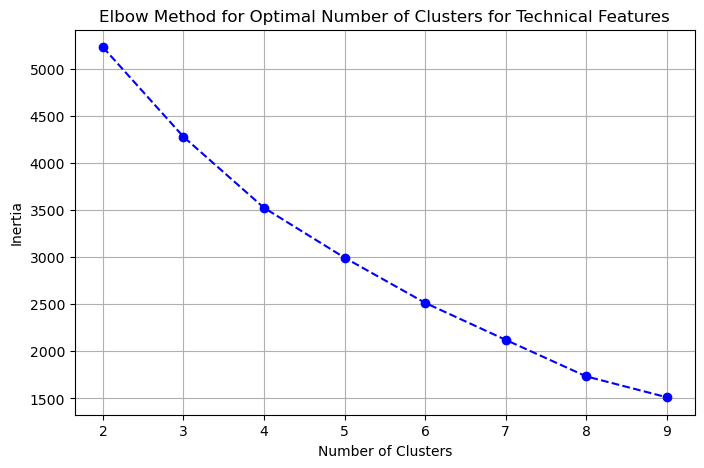

In [22]:
plt.figure(figsize=(8, 5))
plt.plot(cluster_range2, inertia_values2, marker='o', linestyle='--', color='b')
plt.title('Elbow Method for Optimal Number of Clusters for Technical Features')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [26]:
# Fit the final KMeans model with the selected number of clusters
optimal_k_technical = 5  # Choosen based on the elbow plot
kmeans_technical = KMeans(n_clusters=optimal_k_technical, random_state=3101, n_init = 10)
kmeans_technical.fit(features_technical)
subset_technical['Cluster_Labels'] = kmeans_technical.labels_

#Predict cluster labels for the original subset using the same KMeans model
subset_original2['Cluster_Labels'] = kmeans_technical.predict(features_original2)

In [28]:
# Calculate the distribution of PhoneService
phone_service_distribution = (
    subset_technical.groupby('Cluster_Labels')['PhoneService_Encoded']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

# Calculate the distribution of InternetService
internet_service_distribution = (
    subset_technical.groupby('Cluster_Labels')['InternetService_Encoded']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

# Calculate the distribution of TechSupport
tech_support_distribution = (
    subset_technical.groupby('Cluster_Labels')['TechSupport_Encoded']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

# Calculate the distribution of PaperlessBilling
paperless_billing_distribution = (
    subset_technical.groupby('Cluster_Labels')['PaperlessBilling_Encoded']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

# Calculate the distribution of PaymentMethod
payment_method_distribution = (
    subset_technical.groupby('Cluster_Labels')['PaymentMethod_Encoded']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

In [30]:
def generate_synthetic_features(df, distribution):
    synthetic_feature = []
    
    for _, row in df.iterrows():
        cluster = row['Cluster_Labels']
        
        # Sample a new feature based on the defined probabilities
        sample = np.random.choice(
            distribution.columns,  # Possible features to sample from
            p=distribution.loc[cluster].values  # Probabilities for the respective features
        )
        synthetic_feature.append(sample)
            
    return synthetic_feature

# Generate synthetic features
subset_original2['PhoneService'] = generate_synthetic_features(subset_original2, phone_service_distribution)
subset_original2['InternetService'] = generate_synthetic_features(subset_original2, internet_service_distribution)
subset_original2['TechSupport'] = generate_synthetic_features(subset_original2, tech_support_distribution)
subset_original2['PaperlessBilling'] = generate_synthetic_features(subset_original2, paperless_billing_distribution)
subset_original2['PaymentMethod'] = generate_synthetic_features(subset_original2, payment_method_distribution)


### Final dataframe

In [35]:
# Feature from technical
final_tech_features = ['CLIENTNUM','PhoneService','InternetService','TechSupport','PaperlessBilling','PaymentMethod']
temp3  = subset_original2.loc[:,final_tech_features]

# Joingning them all together
final_df = pd.merge(temp4, temp3, on='CLIENTNUM', how = 'inner')

In [37]:
final_df.to_csv('original.csv', index=False)